In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import random
import zipfile
import os
import skimage.transform as skt
import datetime

drive.mount('/content/drive')
folder_name = 'CelebAMask-HQ'
file_dir = '/content/drive/My Drive/' + folder_name + '.zip'
zipfile.ZipFile(file_dir, 'r').extractall()

Mounted at /content/drive


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Thu Dec 24 09:28:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
class EqConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_channel, in_channel, kernel_size[0], kernel_size[1]))
        self.scale = np.sqrt(2./(in_channel * kernel_size[0] * kernel_size[1]))
        self.stride = stride
        self.padding = padding
        self.bias = nn.Parameter(torch.zeros(out_channel)) if bias is True else None

    def forward(self, input):
        return F.conv2d(input, self.weight * self.scale, bias=self.bias, stride=self.stride, padding=self.padding)

class PixelWiseNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(dim=1, keepdim=True) + 1e-8)

class Block(nn.Module):
    def __init__(self, in_channel, out_channel, slope):
        super().__init__()
        self.net = nn.Sequential(
            EqConv2d(in_channel,  out_channel, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            PixelWiseNorm(),
            nn.LeakyReLU(negative_slope=slope),
            EqConv2d(out_channel, out_channel, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            PixelWiseNorm(), 
            nn.LeakyReLU(negative_slope=slope)
        ).to(device)

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fromRGB = nn.ModuleList([
            nn.Sequential(EqConv2d(3,  16,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device),
            nn.Sequential(EqConv2d(3,  32,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device),
            nn.Sequential(EqConv2d(3,  64,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device),
            nn.Sequential(EqConv2d(3, 128,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device),
            nn.Sequential(EqConv2d(3, 256,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device),
            nn.Sequential(EqConv2d(3, 512,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device),
            nn.Sequential(EqConv2d(3, 512,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device),
            nn.Sequential(EqConv2d(3, 512,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device),
            nn.Sequential(EqConv2d(3, 512,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)), nn.LeakyReLU(0.2)).to(device)
        ]).to(device)
        self.net = nn.ModuleList([
            nn.Sequential(Block(16,   32, 0.2), nn.AvgPool2d(2)).to(device),
            nn.Sequential(Block(32,   64, 0.2), nn.AvgPool2d(2)).to(device),
            nn.Sequential(Block(64,  128, 0.2), nn.AvgPool2d(2)).to(device),
            nn.Sequential(Block(128, 256, 0.2), nn.AvgPool2d(2)).to(device),
            nn.Sequential(Block(256, 512, 0.2), nn.AvgPool2d(2)).to(device),
            nn.Sequential(Block(512, 512, 0.2), nn.AvgPool2d(2)).to(device),
            nn.Sequential(Block(512, 512, 0.2), nn.AvgPool2d(2)).to(device),
            nn.Sequential(Block(512, 512, 0.2), nn.AvgPool2d(2)).to(device),
            nn.Sequential(
                EqConv2d(512, 512,  kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                PixelWiseNorm(),
                nn.LeakyReLU(0.2),
                EqConv2d(512, 512,  kernel_size=(4, 4), stride=(1, 1), padding=(0, 0)),
                PixelWiseNorm(),
                nn.LeakyReLU(0.2),
                nn.Flatten(start_dim=1, end_dim=3),
                nn.Linear(512, 1)
            ).to(device),
        ]).to(device)
        self.map = {1024:0, 512:1, 256:2, 128:3, 64:4, 32:5, 16:6, 8:7, 4:8}

    def forward(self, x, alpha):
        scale = x.shape[2]
        if scale == 4 or alpha > 0.9999:
            x = self.net[self.map[scale]](self.fromRGB[self.map[scale]](x))
        else:
            x = alpha * self.net[self.map[scale]](self.fromRGB[self.map[scale]](x)) + (1.0 - alpha) * self.fromRGB[self.map[scale // 2]](F.avg_pool2d(x, 2))
        while scale > 4:
            scale = scale // 2
            x = self.net[self.map[scale]](x)
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.toRGB = nn.ModuleList([
            EqConv2d(512, 3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            EqConv2d(512, 3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            EqConv2d(512, 3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            EqConv2d(512, 3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            EqConv2d(256, 3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            EqConv2d(128, 3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            EqConv2d(64,  3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            EqConv2d(32,  3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            EqConv2d(16,  3,  kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        ]).to(device)
        self.net = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(512, 512,  kernel_size=(4, 4), stride=(1, 1), padding=(0, 0)),
                nn.LeakyReLU(0.2),
                EqConv2d(512, 512,  kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                PixelWiseNorm(),
                nn.LeakyReLU(0.2)
            ).to(device),                              
            nn.Sequential(nn.Upsample(scale_factor=2), Block(512, 512, 0.2)).to(device),
            nn.Sequential(nn.Upsample(scale_factor=2), Block(512, 512, 0.2)).to(device),
            nn.Sequential(nn.Upsample(scale_factor=2), Block(512, 512, 0.2)).to(device),
            nn.Sequential(nn.Upsample(scale_factor=2), Block(512, 256, 0.2)).to(device),
            nn.Sequential(nn.Upsample(scale_factor=2), Block(256, 128, 0.2)).to(device),
            nn.Sequential(nn.Upsample(scale_factor=2), Block(128,  64, 0.2)).to(device),
            nn.Sequential(nn.Upsample(scale_factor=2), Block(64,   32, 0.2)).to(device),
            nn.Sequential(nn.Upsample(scale_factor=2), Block(32,   16, 0.2)).to(device),
        ]).to(device)
        self.map = {4:0, 8:1, 16:2, 32:3, 64:4, 128:5, 256:6, 512:7, 1024:8}

    def forward(self, z, alpha, target_scale):
        scale = 4
        z = z.reshape(-1, 512, 1, 1)
        while scale < target_scale:
            z = self.net[self.map[scale]](z)
            scale = scale * 2
        if scale == 4 or alpha > 0.9999:
            z = self.toRGB[self.map[scale]](self.net[self.map[scale]](z))
        else :
            z = z = alpha * self.toRGB[self.map[scale]](self.net[self.map[scale]](z)) + (1.0 - alpha) * self.toRGB[self.map[scale // 2]](F.interpolate(z, scale_factor=2))
        return torch.tanh(z)

In [5]:
test_noise = torch.randn(64, 512)
def evaluation(size):

    sqrt_num_img = 4
    fig = plt.figure(figsize=(16, 16))
    n = 1
    G.eval()
    for y in range(sqrt_num_img):
        for x in range(sqrt_num_img):
            img = (G(test_noise[n-1].to(device), 1.0, size).detach().cpu().squeeze(0).squeeze(0).permute(1, 2, 0) * 0.5 + 0.5)
            ax = fig.add_subplot(sqrt_num_img, sqrt_num_img, n, xticks=[], yticks=[])
            ax.imshow(img)
            n += 1
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()
    G.train()

In [6]:
from PIL import Image
class DataSet(torch.utils.data.Dataset):
    def __init__(self, scale):
        self.img_loc = 'CelebAMask-HQ/CelebA-HQ-img'
        self.listdir = os.listdir(self.img_loc)
        self.scale = scale

    def __len__(self):
        return len(self.listdir)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_loc, self.listdir[idx])).resize((self.scale, self.scale))
        img = np.uint8(img.copy()).transpose((2, 0, 1))
        return img

def noise(mbsz):
    return torch.randn(mbsz, 512).to(device)


In [7]:
D = Discriminator()
G = Generator()
G_solver = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.0, 0.99))
D_solver = torch.optim.Adam(D.parameters(),  lr=2e-4, betas=(0.0, 0.99))

In [8]:
path = "/content/drive/My Drive/" + "D_pggan512.pt"
D.load_state_dict(torch.load(path, device))
path = "/content/drive/My Drive/" + "G_pggan512.pt"
G.load_state_dict(torch.load(path, device))

<All keys matched successfully>

In [10]:
train_D_true = []
train_D_fake = []

alpha = 0.92
dataset512 = DataSet(512)
loader = DataLoader(dataset=dataset512, batch_size=4, shuffle=True, drop_last=True)
for epoch in range(30):
    train_D_true.append(0.0)
    train_D_fake.append(0.0)
    for data in loader:
        x = (data - 127.5)/127.5 
        x = x.to(device)
        D_solver.zero_grad()
        D_real = D(x, alpha)
        D_fake = D(G(noise(len(x)), alpha, x.shape[2]).detach(), alpha)
        D_adv = (D_real - 1.0).pow(2).mean() + (D_fake + 1.0).pow(2).mean()
        D_adv.backward()
        D_solver.step()

        G_solver.zero_grad()
        G_adv = (D(G(noise(len(x)), alpha, x.shape[2]), alpha)).pow(2).mean()
        G_adv.backward()
        G_solver.step()

        train_D_true[-1] += D_real.mean().item()
        train_D_fake[-1] += D_fake.mean().item()
        alpha += len(x) / 900000.
        if alpha > 1.0:
            alpha = 1.0

    train_D_true[-1] /= len(loader)
    train_D_fake[-1] /= len(loader)
    print(train_D_true[-1], train_D_fake[-1], alpha)

    path = "/content/drive/My Drive/"
    torch.save(G.state_dict(), path + 'G_pggan512.pt')
    torch.save(D.state_dict(), path + 'D_pggan512.pt')
    print(datetime.datetime.now())



print('done!')
evaluation(512)

/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return default_collate([torch.as_tensor(b) for b in batch])


0.9279857146600882 -0.9277749230146408 0.9533333333335517
2020-12-24 10:46:59.819068
0.9255633312821389 -0.9256315356413524 0.9866666666671035
2020-12-24 12:04:22.813355
0.9262248695135117 -0.9261304312944412 1.0
2020-12-24 13:20:36.184027
0.9267489609241486 -0.9266650133132934 1.0
2020-12-24 14:35:56.550280
0.9286201586524645 -0.9287095557053884 1.0
2020-12-24 15:51:02.562516
0.9278747338136037 -0.9277920616348585 1.0
2020-12-24 17:06:01.950985
0.9291906220515569 -0.9290123594999313 1.0
2020-12-24 18:21:26.690265
0.9307580074191093 -0.9309060099959373 1.0
2020-12-24 19:36:53.603290
0.9301963408470154 -0.9302993996183078 1.0
2020-12-24 20:51:26.509380
0.9324326389670372 -0.9323397671262423 1.0
2020-12-24 22:06:00.699091
0.9323020000656446 -0.9322177801410357 1.0
2020-12-24 23:20:30.289811
0.9329648537357649 -0.9330075088659923 1.0
2020-12-25 00:34:46.725207
0.9327948624769846 -0.9328615979870161 1.0
2020-12-25 01:49:43.483520
0.9340816683093707 -0.9340966392278671 1.0
2020-12-25 03:05:

KeyboardInterrupt: ignored

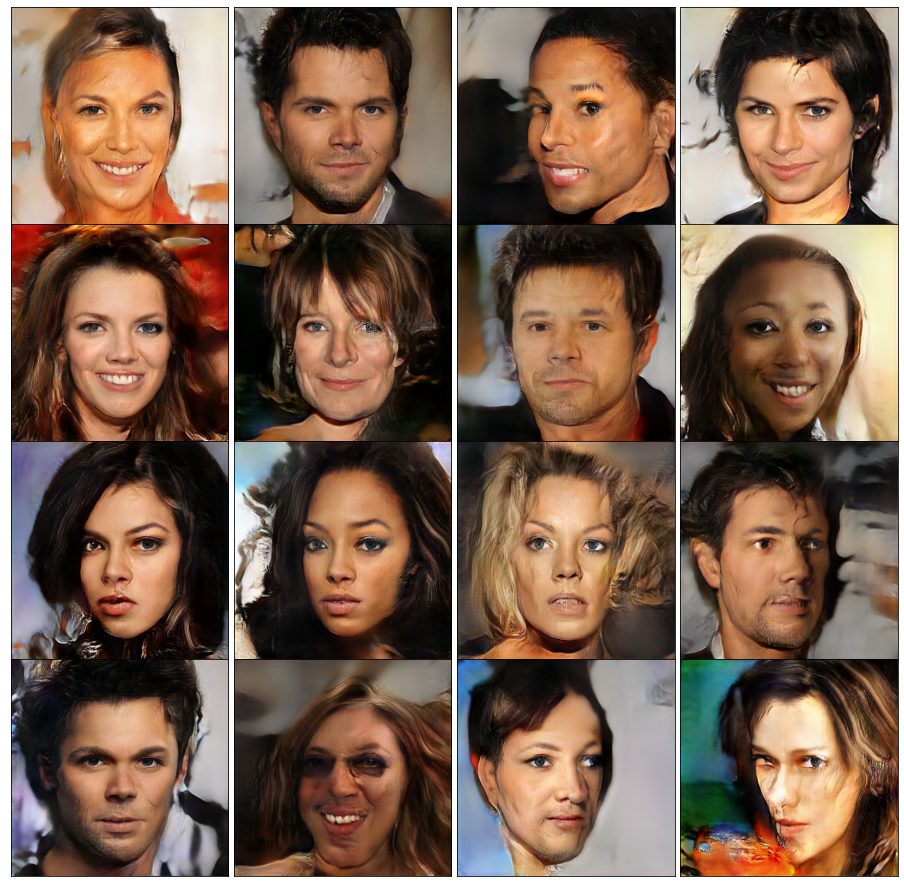

In [11]:
evaluation(512)